# Mutation Free Energy Calculations using BioExcel Building Blocks (biobb)
### Based on the official pmx tutorial: http://pmx.mpibpc.mpg.de/sardinia2018_tutorial1/index.html
***

<div style="background:#b5e0dd;padding:15px;"><strong>Important:</strong> This tutorial is using a <strong>Docker container</strong> to run <strong>pmx</strong>. To use a local installation of <strong>pmx</strong>, just modify the appropriate properties parameter <strong>pmx_cli_path</strong>.</div>

This tutorial aims to illustrate how to compute a **fast-growth** **mutation free energy** calculation, step by step, using the **BioExcel Building Blocks library (biobb)**. The particular example used is the **Staphylococcal nuclease** protein (PDB code 1STN), a small, minimal protein, appropriate for a short tutorial. 

The **non-equilibrium free energy calculation** protocol performs a **fast alchemical transition** in the direction **WT->Mut** and back **Mut->WT**. The two **equilibrium trajectories** needed for the tutorial, one for **Wild Type (WT)** and another for the **Mutated (Mut)** protein (Isoleucine 10 to Alanine -I10A-), have already been generated and are included in this example.  We will name **WT as stateA** and **Mut as stateB**.

<img src="schema.png" />

The tutorial calculates the **free energy difference** in the folded state of a protein. Starting from **two 1ns-length independent equilibrium simulations** (WT and mutant), snapshots are selected to start **fast (50ps) transitions** driving the system in the **forward** (WT to mutant) and **reverse** (mutant to WT) directions, and the **work values** required to perform these transitions are collected. With these values, **Crooks Gaussian Intersection** (CGI), **Bennett Acceptance Ratio** (BAR) and **Jarzynski estimator** methods are used to calculate the **free energy difference** between the two states.

*Please note that for the sake of disk space this tutorial is using 1ns-length equilibrium trajectories, whereas in the [original example](http://pmx.mpibpc.mpg.de/sardinia2018_tutorial1/eq.mdp) the equilibrium trajectories used were obtained from 10ns-length simulations.*
***
**Biobb modules** used:

 - [biobb_pmx](https://github.com/bioexcel/biobb_pmx): Tools to setup and run Alchemical Free Energy calculations.
 - [biobb_md](https://github.com/bioexcel/biobb_md): Tools to setup and run Molecular Dynamics simulations.
 - [biobb_analysis](https://github.com/bioexcel/biobb_analysis): Tools to analyse Molecular Dynamics trajectories.
 
**Auxiliar libraries** used:

 - [nb_conda_kernels](https://github.com/Anaconda-Platform/nb_conda_kernels): Enables a Jupyter Notebook or JupyterLab application in one conda environment to access kernels for Python, R, and other languages found in other environments.
 - [os](https://docs.python.org/3/library/os.html): Python miscellaneous operating system interfaces
 - [plotly](https://plot.ly/python/offline/): Python interactive graphing library integrated in Jupyter notebooks.

### Conda Installation and Launch

```console
git clone https://github.com/bioexcel/biobb_wf_pmx_tutorial.git
cd biobb_wf_pmx_tutorial
conda env create -f conda_env/environment.yml
conda activate biobb_wf_pmx_tutorial
jupyter-notebook biobb_wf_pmx_tutorial/notebooks/biobb_wf_pmx_tutorial.ipynb
  ``` 

***
### Pipeline steps:
 1. [Workflow required files](#input)
 2. [Extract Snapshots from Equilibrium Trajectories](#extract)
 3. [Modelling mutated structure](#mut)
 4. [Create Protein System Topology](#top)
 5. [Generate Hybrid Topology](#hybridtop)
 6. [Creating an index file for the dummy atoms in the morphed structure](#index)
 7. [Energetically Minimize the System](#min)
 8. [Equilibrate the System (NPT)](#npt)
 9. [Free Energy Simulation](#free)
 10. [Free Energy Estimation](#post)
 11. [Output Files](#output)
 12. [Questions & Comments](#questions)

***
<img style="width:400px;" src="logo.png" />

***

<a id="input"></a>
## Workflow required files
Workflow **Input files** needed:
 - **stateA_traj**: Equilibrium trajectory for the **WT protein**.
 - **stateB_traj**: Equilibrium trajectory for the **Mutated protein**.
 - **stateA_tpr**: **WT protein topology** (GROMACS tpr format).
 - **stateB_tpr**: **Mutated protein topology** (GROMACS tpr format).
 
Auxiliar **force field libraries** needed:
 - **mutff45** (folder): pmx mutation force field libraries. 
 
Collected **transitions work values**:  
 - **dhdlA.zip**: **Forward** work values required to illustrate how to perform the last step of the pmx workflow with real values, to extract the **free energy**.
 - **dhdlB.zip**: **Reverse** work values required to illustrate how to perform the last step of the pmx workflow with real values, to extract the **free energy**.
 

In [1]:
import os
import zipfile

cwd = os.getcwd()
gmxlib = os.getenv('CONDA_PREFIX')+'/lib/python3.7/site-packages/pmx/data/mutff45/'

stateA_traj = cwd + "/pmx_tutorial/stateA_1ns.xtc"
stateA_tpr = cwd + "/pmx_tutorial/stateA.tpr"

stateB_traj = cwd + "/pmx_tutorial/stateB_1ns.xtc"
stateB_tpr = cwd + "/pmx_tutorial/stateB.tpr"

<a id="extract"></a>
## Extract Snapshots from Equilibrium Trajectories
**Extract snapshots** from **equilibrium trajectories** (stateA, stateB).

In the **fast-growth method**, the **free energy difference** in the folded state of a protein is calculated from **two independent equilibrium simulations**, **WT** and **mutant**. These simulations need to **sufficiently sample** the **end state ensembles**, as the **free energy accuracy** will depend on the **sampling convergence**. Typically the equilibrium simulations are in the **nanosecond to microsecond time range**. From the generated trajectories, a suitable number of **snapshots** are selected to start **fast (typically 10 - 200 ps) transitions** driving the system in the **forward (WT to mutant)** and **reverse (mutant to WT)** directions. This particular step **extracts the snapshots** from the **input equilibrium trajectories**. 

In this tutorial, just **5 snapshots** for each state (forward, reverse) are generated, for **illustration purposes**. In a real example, both **input trajectories should be longer** (10ns upwards) and the **number of extracted snapshots higher**. The number of suitable number of snapshots depend on the **complexity of the mutation**. Larger perturbations will take **longer to converge** in the simulation, so a smaller or more conservative change might be more promising. 

**WT snapshots**: **stateA**   //    **Mutant snapshots**: **stateB**
***
**Building Blocks** used:
 - [GMXTrjConvStrEns](https://biobb-analysis.readthedocs.io/en/latest/gromacs.html#gromacs-gmx-trjconv-str-ens-module) from **biobb_analysis.gromacs.gmx_trjconv_str_ens**
***

In [2]:
# GMXTrjConvStrEns: extract an ensemble of snapshots from a GROMACS trajectory file
# Import module
from biobb_analysis.gromacs.gmx_trjconv_str_ens import GMXTrjConvStrEns

#### State A ####

# Create prop dict and inputs/outputs (StateA)                          
output_framesA = 'stateA_frames.zip'

prop = {
    'selection' : 'System',
    'start': 1,    # To be changed to generate as many snapshots as needed
    'end': 1000,   # To be changed to generate as many snapshots as needed
    'dt': 200,     # To be changed to generate as many snapshots as needed
    'output_name': 'frameA',
    'output_type': 'pdb'
}

# Create and launch bb (StateA)        
GMXTrjConvStrEns(input_traj_path=stateA_traj,
                 input_top_path=stateA_tpr,
                 output_str_ens_path=output_framesA,
                 properties=prop).launch()

# Extract stateA (WT) frames
with zipfile.ZipFile(output_framesA, 'r') as zip_f:
    zip_f.extractall()
    stateA_pdb_list = zip_f.namelist()
    
#### State B #### 
    
# Create prop dict and inputs/outputs (StateB)                                
output_framesB = 'stateB_frames.zip'  
    
prop = {
    'selection' : 'System',
    'start': 1,   # To be changed to generate as many snapshots as needed
    'end': 1000,  # To be changed to generate as many snapshots as needed
    'dt': 200,    # To be changed to generate as many snapshots as needed
    'output_name': 'frameB',
    'output_type': 'pdb'
}

# Create and launch bb (StateB)
GMXTrjConvStrEns(input_traj_path=stateB_traj,
                 input_top_path=stateB_tpr,
                 output_str_ens_path=output_framesB,
                 properties=prop).launch()
    
# # Extract stateB (Mutant) frames
with zipfile.ZipFile(output_framesB, 'r') as zip_f:
    zip_f.extractall()
    stateB_pdb_list = zip_f.namelist()

2020-10-14 11:34:29,581 [MainThread  ] [INFO ]  Creating 155deb78-8a2e-4e64-86b9-b434b910dd64 temporary folder
2020-10-14 11:34:29,582 [MainThread  ] [INFO ]  Not using any container
2020-10-14 11:34:31,230 [MainThread  ] [INFO ]  echo "System" | gmx trjconv -f /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_pmx_tutorial/biobb_wf_pmx_tutorial/notebooks/pmx_tutorial/stateA_1ns.xtc -s /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_pmx_tutorial/biobb_wf_pmx_tutorial/notebooks/pmx_tutorial/stateA.tpr -skip 1 -b 1 -dt 200 -sep -o 155deb78-8a2e-4e64-86b9-b434b910dd64/frameA.pdb -e 1000

2020-10-14 11:34:31,231 [MainThread  ] [INFO ]  Exit code 0

2020-10-14 11:34:31,231 [MainThread  ] [INFO ]  Note that major changes are planned in future for trjconv, to improve usability and utility.Select group for output
Selected 0: 'System'

2020-10-14 11:34:31,232 [MainThread  ] [INFO ]                       :-) GROMACS - gmx trjconv, 2019.1 (-:

                            GROMACS is wri

2020-10-14 11:34:33,432 [MainThread  ] [INFO ]  Adding:
2020-10-14 11:34:33,434 [MainThread  ] [INFO ]  [PosixPath('c91161bf-8c5e-4481-a188-e2c507da3442/frameB0.pdb'), PosixPath('c91161bf-8c5e-4481-a188-e2c507da3442/frameB1.pdb'), PosixPath('c91161bf-8c5e-4481-a188-e2c507da3442/frameB2.pdb'), PosixPath('c91161bf-8c5e-4481-a188-e2c507da3442/frameB3.pdb'), PosixPath('c91161bf-8c5e-4481-a188-e2c507da3442/frameB4.pdb')]
2020-10-14 11:34:33,434 [MainThread  ] [INFO ]  to: /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_pmx_tutorial/biobb_wf_pmx_tutorial/notebooks/stateB_frames.zip
2020-10-14 11:34:33,439 [MainThread  ] [INFO ]  Removed temporary folder: c91161bf-8c5e-4481-a188-e2c507da3442


***

## WARNING
For the sake of **time**, this tutorial will only compute the work values for **ONE PARTICULAR frame** of each state. In order to reproduce a **real calculation**, the steps presented in this notebook should be **repeated for the rest of the frames**. The **ensemble of computed work values** should then be used in the **final step of the workflow**, the [free energy calculation](#post).    
***

In [3]:
# Prepare Mutation Free Energy calculation for ONE PARTICULAR frame of each state
# (to be repeated for the rest of the frames)
pdbA = stateA_pdb_list[0]
pdbB = stateB_pdb_list[0]

<a id="mut"></a>
## Modelling mutated structures
**Modelling mutated structures** with the desired new residues using **pmx** package. In this case:

**Isoleucine** residue nº10 will be mutated to an **Alanine** in the **forward** transition.

**Alanine** residue nº10 will be mutated to an **Isoleucine** in the **reverse** transition.

*Note:* This tutorial is using a **Docker container** to run **pmx**. To use a local installation of **pmx**, just modify the appropriate properties parameter **pmx_cli_path**. 
***
**Building Blocks** used:
 - [Pmxmutate](https://biobb-pmx.readthedocs.io/en/latest/pmx.html#module-pmx.pmxmutate) from **biobb_pmx.pmx.pmxmutate**
***

## WARNING
The first time that **pmx Docker** container is used, it will be **automatically downloaded** and integrated in the Docker system. This can take **some time, in the order of minutes**, depending on the available **network**. Please, be patient if the workflow gets stuck in this step. 

This process is **only done once**. When the docker is downloaded, the system will locate it and **it will not be required to download again**.     
***

In [4]:
# pmx mutate: Mutate command from pmx package

# Import module
from biobb_pmx.pmx.pmxmutate import Pmxmutate

#### State A (WT->Mut) ####

# Create prop dict and inputs/outputs
output_structure_mutA = 'mutA.pdb'
  
prop = {
    'force_field' : 'amber99sb-star-ildn-mut',
    'mutation_list' : 'Ile10Ala',
    'pmx_path' : 'pmx',
    'gmxlib' : gmxlib
}
# Create and launch bb
Pmxmutate(input_structure_path=pdbA,
       output_structure_path=output_structure_mutA,
       properties=prop).launch()

#### State B (Mut->WT) ####

# Create prop dict and inputs/outputs
output_structure_mutB = 'mutB.pdb'
  
prop = {
    'force_field' : 'amber99sb-star-ildn-mut',
    'mutation_list' : 'Ala10Ile',
    'pmx_path' : 'pmx',
    'gmxlib' : gmxlib
}
# Create and launch bb
Pmxmutate(input_structure_path=pdbB,
       output_structure_path=output_structure_mutB,
       properties=prop).launch()


2020-10-14 11:34:38,080 [MainThread  ] [INFO ]  Not using any container


Ile10Ala


2020-10-14 11:34:40,421 [MainThread  ] [INFO ]  pmx mutate -f frameA0.pdb -o mutA.pdb -ff amber99sb-star-ildn-mut --script /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_pmx_tutorial/biobb_wf_pmx_tutorial/notebooks/5ed4c8bd-5d77-4343-9f61-8ac810c10501/mutations.txt

2020-10-14 11:34:40,422 [MainThread  ] [INFO ]  Exit code 0

2020-10-14 11:34:40,422 [MainThread  ] [INFO ]  log_> Residue to mutate: 10 | ILE | A 
log_> Mutation to apply: I->A
log_> Hybrid residue name: I2A
log_> Inserted hybrid residue I2A at position 10 (chain A)

mutations done...........


2020-10-14 11:34:40,424 [MainThread  ] [INFO ]  Removed: ['/home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_pmx_tutorial/biobb_wf_pmx_tutorial/notebooks/5ed4c8bd-5d77-4343-9f61-8ac810c10501']
2020-10-14 11:34:40,430 [MainThread  ] [INFO ]  Not using any container


Ala10Ile


2020-10-14 11:34:42,541 [MainThread  ] [INFO ]  pmx mutate -f frameB0.pdb -o mutB.pdb -ff amber99sb-star-ildn-mut --script /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_pmx_tutorial/biobb_wf_pmx_tutorial/notebooks/09d9c0f2-ee60-4d5a-a1e7-a82383c399a2/mutations.txt

2020-10-14 11:34:42,542 [MainThread  ] [INFO ]  Exit code 0

2020-10-14 11:34:42,543 [MainThread  ] [INFO ]  log_> Residue to mutate: 10 | ALA | A 
log_> Mutation to apply: A->I
log_> Hybrid residue name: A2I
log_> Inserted hybrid residue A2I at position 10 (chain A)

mutations done...........


2020-10-14 11:34:42,544 [MainThread  ] [INFO ]  Removed: ['/home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_pmx_tutorial/biobb_wf_pmx_tutorial/notebooks/09d9c0f2-ee60-4d5a-a1e7-a82383c399a2']


0

<a id="top"></a>
***
## Create protein system topology
**Building GROMACS topology** for the mutated structures.

The force field used in this tutorial is [**amber99sb-ildn-mut**](https://dx.doi.org/10.1002%2Fprot.22711): AMBER **parm99** force field with **corrections on backbone** (sb) and **side-chain torsion potentials** (ildn), with **pmx library of modelled mutations** (mut). The path to the particular force field used is given as a property to the building block (**gmxlib**), and can be changed to the appropriate location.

Generating two output files: 
- **GROMACS structure** (gro file)
- **GROMACS topology** ZIP compressed file containing:
    - *GROMACS topology top file* (top file)
    - *GROMACS position restraint file/s* (itp file/s)
***
**Building Blocks** used:
 - [Pdb2gmx](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.pdb2gmx) from **biobb_md.gromacs.pdb2gmx**
***

In [5]:
# Create system topology

# Import module
from biobb_md.gromacs.pdb2gmx import Pdb2gmx

#### State A (WT->Mut) ####

# Create inputs/outputs
output_pdb2gmxA_gro = 'pdb2gmxA.gro'
output_pdb2gmxA_top_zip = 'pdb2gmxA_top.zip'
  
prop = {
    'force_field' : 'amber99sb-star-ildn-mut',
    'gmxlib' : gmxlib
}

# Create and launch bb
Pdb2gmx(input_pdb_path=output_structure_mutA,
        output_gro_path=output_pdb2gmxA_gro,
        output_top_zip_path=output_pdb2gmxA_top_zip,
        properties=prop).launch()

#### State B (Mut->WT) ####

# Create inputs/outputs
output_pdb2gmxB_gro = 'pdb2gmxB.gro'
output_pdb2gmxB_top_zip = 'pdb2gmxB_top.zip'
  
prop = {
    'force_field' : 'amber99sb-star-ildn-mut',
    'gmxlib' : gmxlib
}

# Create and launch bb
Pdb2gmx(input_pdb_path=output_structure_mutB,
        output_gro_path=output_pdb2gmxB_gro,
        output_top_zip_path=output_pdb2gmxB_top_zip,
        properties=prop).launch()

2020-10-14 11:34:54,530 [MainThread  ] [INFO ]  GROMACS Pdb2gmx 20191 version detected
2020-10-14 11:34:54,531 [MainThread  ] [INFO ]  Not using any container
2020-10-14 11:34:57,384 [MainThread  ] [INFO ]  gmx -nobackup -nocopyright pdb2gmx -f mutA.pdb -o pdb2gmxA.gro -p p2g.top -water spce -ff amber99sb-star-ildn-mut -i posre.itp

2020-10-14 11:34:57,385 [MainThread  ] [INFO ]  Exit code 0

2020-10-14 11:34:57,385 [MainThread  ] [INFO ]  
Using the Amber99sb-star-ildn-mut force field in directory /anaconda3/envs/biobb_dev_37/lib/python3.7/site-packages/pmx/data/mutff45//amber99sb-star-ildn-mut.ff

going to rename /anaconda3/envs/biobb_dev_37/lib/python3.7/site-packages/pmx/data/mutff45//amber99sb-star-ildn-mut.ff/aminoacids.r2b
going to rename /anaconda3/envs/biobb_dev_37/lib/python3.7/site-packages/pmx/data/mutff45//amber99sb-star-ildn-mut.ff/dna.r2b
going to rename /anaconda3/envs/biobb_dev_37/lib/python3.7/site-packages/pmx/data/mutff45//amber99sb-star-ildn-mut.ff/rna.r2b
Reading 

2020-10-14 11:34:57,387 [MainThread  ] [INFO ]  Compressing topology to: pdb2gmxA_top.zip
2020-10-14 11:34:57,389 [MainThread  ] [INFO ]  Ignored file amber99sb-star-ildn-mut.ff/forcefield.itp
2020-10-14 11:34:57,399 [MainThread  ] [INFO ]  Ignored file amber99sb-star-ildn-mut.ff/spce.itp
2020-10-14 11:34:57,400 [MainThread  ] [INFO ]  Ignored file amber99sb-star-ildn-mut.ff/ions.itp
2020-10-14 11:34:57,407 [MainThread  ] [INFO ]  Adding:
2020-10-14 11:34:57,408 [MainThread  ] [INFO ]  ['p2g.top', 'p2g_Ion_chain_C.itp', 'p2g_Protein_chain_A.itp', 'posre_Ion_chain_C.itp', 'posre_Protein_chain_A.itp']
2020-10-14 11:34:57,410 [MainThread  ] [INFO ]  to: /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_pmx_tutorial/biobb_wf_pmx_tutorial/notebooks/pdb2gmxA_top.zip
2020-10-14 11:34:57,411 [MainThread  ] [INFO ]  Removed: ['p2g.top']
2020-10-14 11:34:57,433 [MainThread  ] [INFO ]  GROMACS Pdb2gmx 20191 version detected
2020-10-14 11:34:57,435 [MainThread  ] [INFO ]  Not using any contai

2020-10-14 11:35:00,885 [MainThread  ] [INFO ]  Compressing topology to: pdb2gmxB_top.zip
2020-10-14 11:35:00,887 [MainThread  ] [INFO ]  Ignored file amber99sb-star-ildn-mut.ff/forcefield.itp
2020-10-14 11:35:00,906 [MainThread  ] [INFO ]  Ignored file amber99sb-star-ildn-mut.ff/spce.itp
2020-10-14 11:35:00,907 [MainThread  ] [INFO ]  Ignored file amber99sb-star-ildn-mut.ff/ions.itp
2020-10-14 11:35:00,911 [MainThread  ] [INFO ]  Adding:
2020-10-14 11:35:00,912 [MainThread  ] [INFO ]  ['p2g.top', 'p2g_Ion_chain_C.itp', 'p2g_Protein_chain_A.itp', 'posre_Ion_chain_C.itp', 'posre_Protein_chain_A.itp']
2020-10-14 11:35:00,913 [MainThread  ] [INFO ]  to: /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_pmx_tutorial/biobb_wf_pmx_tutorial/notebooks/pdb2gmxB_top.zip
2020-10-14 11:35:00,914 [MainThread  ] [INFO ]  Removed: ['p2g.top']


0

<a id="hybridtop"></a>
## Generate Hybrid Topology
**Generate Hybrid Topology** for the mutated structure using **pmx** package, adding the **morphing parameters**. 

*Note:* This tutorial is using a **Docker container** to run **pmx**. To use a local installation of **pmx**, just modify the appropriate properties parameter **pmx_cli_path**. 
***
**Building Blocks** used:
 - [Pmxgentop](https://biobb-pmx.readthedocs.io/en/latest/pmx.html#module-pmx.pmxgentop) from **biobb_pmx.pmx.pmxgentop**
***

In [6]:
# pmx gentop: Gentop command (Generate Hybrid Topology) from pmx package

# Import module
from biobb_pmx.pmx.pmxgentop import Pmxgentop

#### State A (WT->Mut) ####

# Create prop dict and inputs/outputs
output_pmxtopA_top_zip = 'pmxA_top.zip'
output_pmxtopA_log = 'pmxA_top.log'
  
prop = {
    'force_field' : 'amber99sb-star-ildn-mut',
    'pmx_path' : 'pmx',
    'gmxlib' : gmxlib
}

#Create and launch bb
Pmxgentop(input_top_zip_path=output_pdb2gmxA_top_zip,
       output_top_zip_path=output_pmxtopA_top_zip,
       output_log_path=output_pmxtopA_log,
       properties=prop).launch()

#### State B (Mut->WT) ####

# Create prop dict and inputs/outputs
output_pmxtopB_top_zip = 'pmxB_top.zip'
output_pmxtopB_log = 'pmxB_top.log'
  
prop = {
    'force_field' : 'amber99sb-star-ildn-mut',
    'pmx_path' : 'pmx',
    'gmxlib' : gmxlib
}

# Create and launch bb
Pmxgentop(input_top_zip_path=output_pdb2gmxB_top_zip,
       output_top_zip_path=output_pmxtopB_top_zip,
       output_log_path=output_pmxtopB_log,
       properties=prop).launch()

2020-10-14 11:35:06,087 [MainThread  ] [INFO ]  Extracting: /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_pmx_tutorial/biobb_wf_pmx_tutorial/notebooks/pdb2gmxA_top.zip
2020-10-14 11:35:06,087 [MainThread  ] [INFO ]  to:
2020-10-14 11:35:06,088 [MainThread  ] [INFO ]  ['6acb209d-e33b-49ef-b3de-d3c92bc7571a/p2g.top', '6acb209d-e33b-49ef-b3de-d3c92bc7571a/p2g_Ion_chain_C.itp', '6acb209d-e33b-49ef-b3de-d3c92bc7571a/p2g_Protein_chain_A.itp', '6acb209d-e33b-49ef-b3de-d3c92bc7571a/posre_Ion_chain_C.itp', '6acb209d-e33b-49ef-b3de-d3c92bc7571a/posre_Protein_chain_A.itp']
2020-10-14 11:35:06,089 [MainThread  ] [INFO ]  Unzipping: 
2020-10-14 11:35:06,089 [MainThread  ] [INFO ]  pdb2gmxA_top.zip
2020-10-14 11:35:06,090 [MainThread  ] [INFO ]  To: 
2020-10-14 11:35:06,091 [MainThread  ] [INFO ]  6acb209d-e33b-49ef-b3de-d3c92bc7571a/p2g.top
2020-10-14 11:35:06,091 [MainThread  ] [INFO ]  6acb209d-e33b-49ef-b3de-d3c92bc7571a/p2g_Ion_chain_C.itp
2020-10-14 11:35:06,092 [MainThread  ] [INFO ]

2020-10-14 11:35:14,227 [MainThread  ] [INFO ]  Check if d4eefca9-ab38-4ced-886c-2c03296a0cc3/p2g.top exists
2020-10-14 11:35:14,228 [MainThread  ] [INFO ]  Check if d4eefca9-ab38-4ced-886c-2c03296a0cc3/p2g_Protein_chain_A.itp exists
2020-10-14 11:35:14,230 [MainThread  ] [INFO ]  Copying 5a1ca8a9-f595-411a-b77c-8698590ac7d3/p2g_Protein_chain_A.itp to: d4eefca9-ab38-4ced-886c-2c03296a0cc3
2020-10-14 11:35:14,230 [MainThread  ] [INFO ]  Check if d4eefca9-ab38-4ced-886c-2c03296a0cc3/posre_Ion_chain_C.itp exists
2020-10-14 11:35:14,231 [MainThread  ] [INFO ]  Copying 5a1ca8a9-f595-411a-b77c-8698590ac7d3/posre_Ion_chain_C.itp to: d4eefca9-ab38-4ced-886c-2c03296a0cc3
2020-10-14 11:35:14,232 [MainThread  ] [INFO ]  Check if d4eefca9-ab38-4ced-886c-2c03296a0cc3/posre_Protein_chain_A.itp exists
2020-10-14 11:35:14,233 [MainThread  ] [INFO ]  Copying 5a1ca8a9-f595-411a-b77c-8698590ac7d3/posre_Protein_chain_A.itp to: d4eefca9-ab38-4ced-886c-2c03296a0cc3
2020-10-14 11:35:14,234 [MainThread  ] [IN

0

<a id="index"></a>
## Creating an index file for the dummy atoms in the morphed structure

Some of the **mutations** done to the protein residues involve the generation of **dummy atoms**, atoms that are **slowly appearing** during the **transition** from the WT to the mutated structure. These **dummy atoms** need to be energy minimized before starting the **thermodynamic integration** step. If there are **no dummy atoms** in the corresponding state, this **energy minimization step can be omitted**.

In this particular example, the **WT to mutated protein transition** (Isoleucine to Alanine) is not generating any **dummy atoms**, so it does not need any minimization step. Conversely, the **mutated to WT transition** (Alanine to Isoleucine) is generating 9 **dummy atoms**, so the minimization step is needed for the **reverse transition** (stateB).

The **GROMACS** index file is built to **identify the dummy atoms** in the following **energy minimization** step, generating a new **FREEZE group** containing all atoms of the system except the **dummy atoms**. In the minimization process, this group will be **kept frozen**, whereas the **dummy atoms** will be left able to move. 
***
**Building Blocks** used:
 - [MakeNdx](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.make_ndx) from **biobb_md.gromacs.make_ndx**
***

In [7]:
# Gromacs make_ndx: GROMACS Make index command from biobb_md package
# IMPORTANT: Only needed for stateB

# Import module
from biobb_md.gromacs.make_ndx import MakeNdx

# Create prop dict and inputs/outputs
output_ndx = 'indexB.ndx'
  
prop = {
    'selection' : 'a D*\n0 & ! 19\nname 20 FREEZE'
}

# Create and launch bb
MakeNdx(input_structure_path=output_pdb2gmxB_gro,
        output_ndx_path=output_ndx,
        properties=prop).launch()

2020-10-14 11:35:18,988 [MainThread  ] [INFO ]  GROMACS MakeNdx 20191 version detected
2020-10-14 11:35:18,990 [MainThread  ] [INFO ]  Not using any container
2020-10-14 11:35:19,510 [MainThread  ] [INFO ]  echo -e 'a D*
0 & ! 19
name 20 FREEZE\nq' | gmx -nobackup -nocopyright make_ndx -f pdb2gmxB.gro -o indexB.ndx

2020-10-14 11:35:19,511 [MainThread  ] [INFO ]  Exit code 0

2020-10-14 11:35:19,511 [MainThread  ] [INFO ]  Going to read 0 old index file(s)
Analysing residue names:
There are:   135    Protein residues
There are:    75      Other residues
There are: 10949      Water residues
Analysing Protein...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...

  0 System              : 35147 atoms
  1 Protein             :  2207 atoms
  2 Protein-H           :  1084 atoms
  3 C-alpha             :   135 atoms
  4 Backbone            :   405 atoms
  5 MainChain           :   541 atoms
  6 MainChain+Cb        :   667 atoms
  7 MainChain+H         :  

0

<a id="min"></a>
***
## Energetically minimize the system
Energetically minimize the **mutated protein** till reaching a desired potential energy.
- [Step 1](#emStep1): Creating portable binary run file for energy minimization
- [Step 2](#emStep2): Energetically minimize the **dummy atoms** till reaching a force of 100 kJ mol-1 nm-1.
- [Step 3](#emStep3): Checking **energy minimization** results. Plotting energy by time during the **minimization** process.
***
**Building Blocks** used:
 - [Grompp](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.grompp) from **biobb_md.gromacs.grompp** 
 - [Mdrun](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.mdrun) from **biobb_md.gromacs.mdrun** 
 - [GMXEnergy](https://biobb-analysis.readthedocs.io/en/latest/gromacs.html#module-gromacs.gmx_energy) from **biobb_analysis.gromacs.gmx_energy** 
***

<a id="emStep1"></a>
### Step 1: Creating portable binary run file for energy minimization

Method used to run the **energy minimization** is a **steepest descent**, with a **maximum force of 100 KJ/mol\*nm^2**, and a minimization **step size of 1fs**. The **maximum number of steps** to perform if the maximum force is not reached is **10,000 steps**. The previously generated **FREEZE** group is used to keep the system frozen except for the **dummy atoms**.

Please note that as previously described, for the stateA (forward transition, Isoleucine to Alanine mutation), as there are no dummies, **the energy minimization is omitted** and **the energy minimization step is skipped**. 

In [8]:
# Grompp: Creating portable binary run file for dummy atoms energy minimization
from biobb_md.gromacs.grompp import Grompp

#### State B (Mut->WT) ####

# Create prop dict and inputs/outputs
output_tpr_min = 'em.tpr'

prop = {
    'gmxlib' : gmxlib,
    'mdp':{
        'type': 'minimization',
        'integrator' : 'steep',
        'emtol': '100',
        'dt': '0.001',
        'nsteps':'10000',
        'nstcomm': '1',
        'nstcalcenergy': '1',
        'freezegrps' : 'FREEZE',
        'freezedim' : "Y Y Y"
    }
}

# Create and launch bb
Grompp(input_gro_path=output_pdb2gmxB_gro,
       input_top_zip_path=output_pmxtopB_top_zip,
       input_ndx_path=output_ndx,
       output_tpr_path=output_tpr_min,
       properties=prop).launch()

2020-10-14 11:35:22,886 [MainThread  ] [INFO ]  GROMACS Grompp 20191 version detected
2020-10-14 11:35:22,892 [MainThread  ] [INFO ]  Extracting: /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_pmx_tutorial/biobb_wf_pmx_tutorial/notebooks/pmxB_top.zip
2020-10-14 11:35:22,893 [MainThread  ] [INFO ]  to:
2020-10-14 11:35:22,894 [MainThread  ] [INFO ]  ['2dcd8b3d-29cb-4d2d-95f1-9c9a2b0d2d95/p2g.top', '2dcd8b3d-29cb-4d2d-95f1-9c9a2b0d2d95/pmx_p2g_Ion_chain_C.itp', '2dcd8b3d-29cb-4d2d-95f1-9c9a2b0d2d95/pmx_p2g_Protein_chain_A.itp', '2dcd8b3d-29cb-4d2d-95f1-9c9a2b0d2d95/posre_Ion_chain_C.itp', '2dcd8b3d-29cb-4d2d-95f1-9c9a2b0d2d95/posre_Protein_chain_A.itp']
2020-10-14 11:35:22,895 [MainThread  ] [INFO ]  Unzipping: 
2020-10-14 11:35:22,896 [MainThread  ] [INFO ]  pmxB_top.zip
2020-10-14 11:35:22,897 [MainThread  ] [INFO ]  To: 
2020-10-14 11:35:22,898 [MainThread  ] [INFO ]  2dcd8b3d-29cb-4d2d-95f1-9c9a2b0d2d95/p2g.top
2020-10-14 11:35:22,899 [MainThread  ] [INFO ]  2dcd8b3d-29cb-4d2

0

<a id="emStep2"></a>
### Step 2: Running Energy Minimization
Running **energy minimization** using the **tpr file** generated in the previous step.

In [9]:
# Mdrun: Running minimization
from biobb_md.gromacs.mdrun import Mdrun

# Create prop dict and inputs/outputs
output_min_trr = 'emout.trr'
output_min_gro = 'emout.gro'
output_min_edr = 'emout.edr'
output_min_log = 'emout.log'

# Create and launch bb
Mdrun(input_tpr_path=output_tpr_min,
      output_trr_path=output_min_trr,
      output_gro_path=output_min_gro,
      output_edr_path=output_min_edr,
      output_log_path=output_min_log).launch()

2020-10-14 11:35:29,865 [MainThread  ] [INFO ]  GROMACS Mdrun 20191 version detected
2020-10-14 11:35:29,866 [MainThread  ] [INFO ]  Not using any container
2020-10-14 11:35:33,594 [MainThread  ] [INFO ]  gmx -nobackup -nocopyright mdrun -s em.tpr -o emout.trr -c emout.gro -e emout.edr -g emout.log -nt 0

2020-10-14 11:35:33,594 [MainThread  ] [INFO ]  Exit code 0

2020-10-14 11:35:33,595 [MainThread  ] [INFO ]                        :-) GROMACS - gmx mdrun, 2019.1 (-:

Executable:   /anaconda3/envs/biobb_dev_37/bin/gmx
Data prefix:  /anaconda3/envs/biobb_dev_37
Working dir:  /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_pmx_tutorial/biobb_wf_pmx_tutorial/notebooks
Command line:
  gmx -nobackup -nocopyright mdrun -s em.tpr -o emout.trr -c emout.gro -e emout.edr -g emout.log -nt 0

Compiled SIMD: SSE2, but for this host/run AVX2_256 might be better (see log).
The current CPU can measure timings more accurately than the code in
gmx mdrun was configured to use. This might affect 

0

<a id="emStep3"></a>
### Step 3: Checking Energy Minimization results
Checking **energy minimization** results. Plotting **potential energy** by time during the minimization process. 

In [10]:
# GMXEnergy: Getting system energy by time  
from biobb_analysis.gromacs.gmx_energy import GMXEnergy

# Create prop dict and inputs/outputs
output_min_ene_xvg = 'min_ene.xvg'
prop = {
    'terms':  ["Potential"]
}

# Create and launch bb
GMXEnergy(input_energy_path=output_min_edr, 
          output_xvg_path=output_min_ene_xvg, 
          properties=prop).launch()

2020-10-14 11:35:48,182 [MainThread  ] [INFO ]  Not using any container
2020-10-14 11:35:48,195 [MainThread  ] [INFO ]  gmx energy -f /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_pmx_tutorial/biobb_wf_pmx_tutorial/notebooks/emout.edr -o min_ene.xvg -xvg none < 2197f6da-9a24-4ff5-968d-4e238c1655a4/instructions.in

2020-10-14 11:35:48,197 [MainThread  ] [INFO ]  Exit code 0

2020-10-14 11:35:48,198 [MainThread  ] [INFO ]  
Statistics over 42 steps [ 0.0000 through 41.0000 ps ], 1 data sets
All statistics are over 31 points (frames)

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Potential                   -525653         73    225.442   -414.764  (kJ/mol)

2020-10-14 11:35:48,198 [MainThread  ] [INFO ]                        :-) GROMACS - gmx energy, 2019.1 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman 

0

In [11]:
import plotly
import plotly.graph_objs as go

# Read data from file and filter energy values higher than 1000 Kj/mol^-1
with open(output_min_ene_xvg,'r') as energy_file:
    x,y = map(
        list,
        zip(*[
            (float(line.split()[0]),float(line.split()[1]))
            for line in energy_file 
            if not line.startswith(("#","@")) 
            if float(line.split()[1]) < 1000 
        ])
    )

plotly.offline.init_notebook_mode(connected=True)

fig = ({
    "data": [go.Scatter(x=x, y=y)],
    "layout": go.Layout(title="Energy Minimization",
                        xaxis=dict(title = "Energy Minimization Step"),
                        yaxis=dict(title = "Potential Energy KJ/mol-1")
                       )
})

plotly.offline.iplot(fig)

<a id="npt"></a>
***
## Equilibrate the system (NPT)
Equilibrate the **protein system** in **NPT** ensemble (constant Number of particles, Pressure and Temperature).
- [Step 1](#eqNPTStep1): Creating portable binary run file for system equilibration
- [Step 2](#eqNPTStep2): Equilibrate the **protein system** with **NPT** ensemble.
- [Step 3](#eqNPTStep3): Checking **NPT Equilibration** results. Plotting **system pressure and density** by time during the **NPT equilibration** process.
***
**Building Blocks** used:
 - [Grompp](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.grompp) from **biobb_md.gromacs.grompp** 
 - [Mdrun](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.mdrun) from **biobb_md.gromacs.mdrun** 
 - [GMXEnergy](https://biobb-analysis.readthedocs.io/en/latest/gromacs.html#module-gromacs.gmx_energy) from **biobb_analysis.gromacs.gmx_energy** 
***

<a id="eqNPTStep1"></a>
### Step 1: Creating portable binary run file for system equilibration (NPT)

The **npt** type of the **molecular dynamics parameters (mdp) property** contains the main default parameters to run an **NPT equilibration** with **protein restraints** (see [GROMACS mdp options](http://manual.gromacs.org/documentation/2018/user-guide/mdp-options.html)):

-  integrator               = md
-  dt                       = 0.001
-  nsteps                   = 10000
-  pcoupl = Parrinello-Rahman
-  pcoupltype = isotropic
-  tau_p = 1.0
-  ref_p = 1.0
-  compressibility = 4.5e-5
-  refcoord_scaling = com
-  gen_vel = no

In this particular example, the default parameters will be used: **md** integrator algorithm, a **time step** of **2fs**, **5,000 equilibration steps**, and a Parrinello-Rahman **pressure coupling** algorithm.

*Please note that for the sake of time this tutorial is only running 10ps of NPT equilibration, whereas in the [original example](http://pmx.mpibpc.mpg.de/sardinia2018_tutorial1/eq.mdp) the simulated time was 100ps.*

In [12]:
# Grompp: Creating portable binary run file for system equilibration
from biobb_md.gromacs.grompp import Grompp

#### State A (WT->Mut) ####

# Create prop dict and inputs/outputs
output_tprA_eq = 'eqA_20ps.tpr'

prop = {
    'gmxlib' : gmxlib,
    'mdp':{
        'type': 'free',
        'nsteps':'10000',
        'nstcomm' : '1',
        'dt':'0.001',
        'nstcalcenergy' : '1'
    }
    
}

#Create and launch bb
Grompp(input_gro_path=output_pdb2gmxA_gro,
       input_top_zip_path=output_pmxtopA_top_zip,
       output_tpr_path=output_tprA_eq,
       properties=prop).launch()


#### State B (Mut->WT) ####

# Create prop dict and inputs/outputs
output_tprB_eq = 'eqB_20ps.tpr'

prop = {
    'gmxlib' : gmxlib,
    'mdp':{
        'type': 'free',
        'nsteps':'10000', # 10000 steps x 1fs (timestep) = 10ps 
        'dt':'0.001', # 1 fs of timestep, to properly equilibrate dummy atoms
        'nstcomm' : '1',
        'nstcalcenergy' : '1'
    }
}
#Create and launch bb
Grompp(input_gro_path=output_min_gro,
       input_top_zip_path=output_pmxtopB_top_zip,
       output_tpr_path=output_tprB_eq,
       properties=prop).launch()


2020-10-14 11:36:43,584 [MainThread  ] [INFO ]  GROMACS Grompp 20191 version detected
2020-10-14 11:36:43,589 [MainThread  ] [INFO ]  Extracting: /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_pmx_tutorial/biobb_wf_pmx_tutorial/notebooks/pmxA_top.zip
2020-10-14 11:36:43,590 [MainThread  ] [INFO ]  to:
2020-10-14 11:36:43,591 [MainThread  ] [INFO ]  ['92968317-411f-4891-8a50-9cd6390f32ee/p2g.top', '92968317-411f-4891-8a50-9cd6390f32ee/pmx_p2g_Ion_chain_C.itp', '92968317-411f-4891-8a50-9cd6390f32ee/pmx_p2g_Protein_chain_A.itp', '92968317-411f-4891-8a50-9cd6390f32ee/posre_Ion_chain_C.itp', '92968317-411f-4891-8a50-9cd6390f32ee/posre_Protein_chain_A.itp']
2020-10-14 11:36:43,591 [MainThread  ] [INFO ]  Unzipping: 
2020-10-14 11:36:43,592 [MainThread  ] [INFO ]  pmxA_top.zip
2020-10-14 11:36:43,592 [MainThread  ] [INFO ]  To: 
2020-10-14 11:36:43,593 [MainThread  ] [INFO ]  92968317-411f-4891-8a50-9cd6390f32ee/p2g.top
2020-10-14 11:36:43,593 [MainThread  ] [INFO ]  92968317-411f-489

2020-10-14 11:36:44,278 [MainThread  ] [INFO ]  Removed: ['mdout.mdp', '14b81b38-9919-45cc-a0a0-c79dc7435b27', '6e3e3e1c-0954-4739-94bc-d3474ad0bf93']


0

<a id="eqNPTStep2"></a>
### Step 2: Running NPT equilibration

In [13]:
# Mdrun: Running equilibration
from biobb_md.gromacs.mdrun import Mdrun

#### State A (WT->Mut) ####

# Create prop dict and inputs/outputs
output_eqA_trr = 'eqoutA.trr'
output_eqA_gro = 'eqoutA.gro'
output_eqA_edr = 'eqoutA.edr'
output_eqA_log = 'eqoutA.log'

# Create and launch bb
Mdrun(input_tpr_path=output_tprA_eq,
      output_trr_path=output_eqA_trr,
      output_gro_path=output_eqA_gro,
      output_edr_path=output_eqA_edr,
      output_log_path=output_eqA_log).launch()

#### State B (Mut->WT) ####

# Create prop dict and inputs/outputs
output_eqB_trr = 'eqoutB.trr'
output_eqB_gro = 'eqoutB.gro'
output_eqB_edr = 'eqoutB.edr'
output_eqB_log = 'eqoutB.log'

# Create and launch bb
Mdrun(input_tpr_path=output_tprB_eq,
      output_trr_path=output_eqB_trr,
      output_gro_path=output_eqB_gro,
      output_edr_path=output_eqB_edr,
      output_log_path=output_eqB_log).launch()

2020-10-14 11:36:48,583 [MainThread  ] [INFO ]  GROMACS Mdrun 20191 version detected
2020-10-14 11:36:48,585 [MainThread  ] [INFO ]  Not using any container
2020-10-14 11:40:35,509 [MainThread  ] [INFO ]  gmx -nobackup -nocopyright mdrun -s eqA_20ps.tpr -o eqoutA.trr -c eqoutA.gro -e eqoutA.edr -g eqoutA.log -nt 0

2020-10-14 11:40:35,509 [MainThread  ] [INFO ]  Exit code 0

2020-10-14 11:40:35,510 [MainThread  ] [INFO ]                        :-) GROMACS - gmx mdrun, 2019.1 (-:

Executable:   /anaconda3/envs/biobb_dev_37/bin/gmx
Data prefix:  /anaconda3/envs/biobb_dev_37
Working dir:  /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_pmx_tutorial/biobb_wf_pmx_tutorial/notebooks
Command line:
  gmx -nobackup -nocopyright mdrun -s eqA_20ps.tpr -o eqoutA.trr -c eqoutA.gro -e eqoutA.edr -g eqoutA.log -nt 0

Compiled SIMD: SSE2, but for this host/run AVX2_256 might be better (see log).
The current CPU can measure timings more accurately than the code in
gmx mdrun was configured to use

0

<a id="eqNPTStep3"></a>
### Step 3: Checking NPT Equilibration results
Checking **NPT Equilibration** results. Plotting **system pressure and density** by time during the **NPT equilibration** process. 

In [15]:
# GMXEnergy: Getting system pressure and density by time during NPT Equilibration  
from biobb_analysis.gromacs.gmx_energy import GMXEnergy

#### State A (WT->Mut) ####

# Create prop dict and inputs/outputs
output_eqA_pd_xvg = 'eqA_PD.xvg'
prop = {
    'terms':  ["Pressure","Density"]
}

# Create and launch bb
GMXEnergy(input_energy_path=output_eqA_edr, 
          output_xvg_path=output_eqA_pd_xvg, 
          properties=prop).launch()

#### State B (Mut->WT) ####

# Create prop dict and inputs/outputs
output_eqB_pd_xvg = 'eqB_PD.xvg'
prop = {
    'terms':  ["Pressure","Density"]
}

# Create and launch bb
GMXEnergy(input_energy_path=output_eqB_edr, 
          output_xvg_path=output_eqB_pd_xvg, 
          properties=prop).launch()

2020-10-14 11:45:04,544 [MainThread  ] [INFO ]  Not using any container
2020-10-14 11:45:04,560 [MainThread  ] [INFO ]  gmx energy -f /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_pmx_tutorial/biobb_wf_pmx_tutorial/notebooks/eqoutA.edr -o eqA_PD.xvg -xvg none < 28319c71-6667-4319-90df-a31048575512/instructions.in

2020-10-14 11:45:04,561 [MainThread  ] [INFO ]  Exit code 0

2020-10-14 11:45:04,561 [MainThread  ] [INFO ]  
Statistics over 10001 steps [ 0.0000 through 10.0000 ps ], 2 data sets
All statistics are over 10001 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Pressure                   -135.276         --    2602.53    519.349  (bar)
Density                     1013.23         --    32.3523    45.4076  (kg/m^3)

2020-10-14 11:45:04,562 [MainThread  ] [INFO ]                        :-) GROMACS - gmx energy, 2019.1 (-:

                            GROMACS is writ

2020-10-14 11:45:04,598 [MainThread  ] [INFO ]  Removed: [PurePosixPath('c48121a4-a29b-4321-b74a-7288ee61acbb')]


0

Please note the information shown by the next plots **increases with the time simulated**, and are included as a **reference for more complex calculations**.   

In [16]:
import plotly
from plotly import subplots
import plotly.graph_objs as go

# Read pressure and density data from file 
with open(output_eqA_pd_xvg,'r') as pd_file:
    x,y,z = map(
        list,
        zip(*[
            (float(line.split()[0]),float(line.split()[1]),float(line.split()[2]))
            for line in pd_file 
            if not line.startswith(("#","@")) 
        ])
    )

plotly.offline.init_notebook_mode(connected=True)

trace1 = go.Scatter(
    x=x,y=y
)
trace2 = go.Scatter(
    x=x,y=z
)

fig = subplots.make_subplots(rows=1, cols=2, print_grid=False)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)

fig['layout']['xaxis1'].update(title='Time (ps)')
fig['layout']['xaxis2'].update(title='Time (ps)')
fig['layout']['yaxis1'].update(title='Pressure (bar)')
fig['layout']['yaxis2'].update(title='Density (Kg*m^-3)')

fig['layout'].update(title='Pressure and Density during NPT Equilibration')
fig['layout'].update(showlegend=False)

plotly.offline.iplot(fig)

In [17]:
import plotly
from plotly import subplots
import plotly.graph_objs as go

# Read pressure and density data from file 
with open(output_eqB_pd_xvg,'r') as pd_file:
    x,y,z = map(
        list,
        zip(*[
            (float(line.split()[0]),float(line.split()[1]),float(line.split()[2]))
            for line in pd_file 
            if not line.startswith(("#","@")) 
        ])
    )

plotly.offline.init_notebook_mode(connected=True)

trace1 = go.Scatter(
    x=x,y=y
)
trace2 = go.Scatter(
    x=x,y=z
)

fig = subplots.make_subplots(rows=1, cols=2, print_grid=False)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)

fig['layout']['xaxis1'].update(title='Time (ps)')
fig['layout']['xaxis2'].update(title='Time (ps)')
fig['layout']['yaxis1'].update(title='Pressure (bar)')
fig['layout']['yaxis2'].update(title='Density (Kg*m^-3)')

fig['layout'].update(title='Pressure and Density during NPT Equilibration')
fig['layout'].update(showlegend=False)

plotly.offline.iplot(fig)

<a id="free"></a>
***
## Free Energy Simulation
**Alchemical transition (thermodynamic integration)** free energy estimation approach is used with **GROMACS**: **free energy** is switched on, the **initial lambda** is chosen as zero, and **delta-lambda** (per MD step) is set such that at the end of the simulation **lambda** is at 1 (1 / nsteps). The **dhdl files** (dH/dl) written as a result will contain the **work values** required to perform these **transitions**.

- [Step 1](#mdStep1): Creating portable binary run file to run the **free energy simulation**.
- [Step 2](#mdStep2): Run short MD simulation of the **protein system**.
***
**Building Blocks** used:
 - [Grompp](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.grompp) from **biobb_md.gromacs.grompp** 
 - [Mdrun](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.mdrun) from **biobb_md.gromacs.mdrun** 
***

<a id="mdStep1"></a>
### Step 1: Creating portable binary run file to run a free energy simulation

The **free_energy** type of the **molecular dynamics parameters (mdp) property** contains the main default parameters to run an **free energy simulation** (see [GROMACS mdp options](http://manual.gromacs.org/documentation/2018/user-guide/mdp-options.html)):

-  integrator               = md
-  dt                       = 0.002 (ps)
-  nsteps                   = 5000
-  free_energy              = yes
-  init_lambda              = 0
-  delta_lambda             = 0.0002
-  sc-alpha                 = 0
-  sc-sigma                 = 0.3

In this particular example, the default parameters will be used: **md** integrator algorithm, a **time step** of **2fs**, a total of **5,000 md steps** (10ps), all with the **free energy** flag turned on, with an **intial lambda** of 0 and a **delta lambda** of 0.00002.

*Please note that for the sake of time this tutorial is only running 10ps of NPT equilibration, whereas in the [original example](http://pmx.mpibpc.mpg.de/sardinia2018_tutorial1/eq.mdp) the simulated time was 100ps.*

In [18]:
# Grompp: Creating portable binary run file for thermodynamic integration (TI)
from biobb_md.gromacs.grompp import Grompp

#### State A (WT->Mut) ####

# Create prop dict and inputs/outputs
output_tprA_ti = 'tiA.tpr'

prop = {
    'gmxlib' : gmxlib,
    'mdp':{
        'type': 'free',
        'nsteps':'5000',
        'free_energy' : 'yes',
        'init-lambda' : '0',
        'delta-lambda' : '2e-4',
        'sc-alpha' : '0.3',
        'sc-coul' : 'yes',
        'sc-sigma' : '0.25'
    }
}

# Create and launch bb
Grompp(input_gro_path=output_eqA_gro,
       input_top_zip_path=output_pmxtopA_top_zip,
       output_tpr_path=output_tprA_ti,
       properties=prop).launch()

#### State B (Mut->WT) ####

# Create prop dict and inputs/outputs
output_tprB_ti = 'tiB.tpr'

prop = {
    'gmxlib' : gmxlib,
    'mdp':{
        'type': 'free',
        'nsteps':'5000',
        'free_energy' : 'yes',
        'init-lambda' : '0',
        'delta-lambda' : '4e-5',
        'sc-alpha' : '0.3',
        'sc-coul' : 'yes',
        'sc-sigma' : '0.25'
    }
}

# Create and launch bb
Grompp(input_gro_path=output_eqB_gro,
       input_top_zip_path=output_pmxtopB_top_zip,
       output_tpr_path=output_tprB_ti,
       properties=prop).launch()


2020-10-14 11:45:25,162 [MainThread  ] [INFO ]  GROMACS Grompp 20191 version detected
2020-10-14 11:45:25,169 [MainThread  ] [INFO ]  Extracting: /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_pmx_tutorial/biobb_wf_pmx_tutorial/notebooks/pmxA_top.zip
2020-10-14 11:45:25,170 [MainThread  ] [INFO ]  to:
2020-10-14 11:45:25,170 [MainThread  ] [INFO ]  ['db8873ce-e59c-4efc-9f6a-f5c89122899f/p2g.top', 'db8873ce-e59c-4efc-9f6a-f5c89122899f/pmx_p2g_Ion_chain_C.itp', 'db8873ce-e59c-4efc-9f6a-f5c89122899f/pmx_p2g_Protein_chain_A.itp', 'db8873ce-e59c-4efc-9f6a-f5c89122899f/posre_Ion_chain_C.itp', 'db8873ce-e59c-4efc-9f6a-f5c89122899f/posre_Protein_chain_A.itp']
2020-10-14 11:45:25,171 [MainThread  ] [INFO ]  Unzipping: 
2020-10-14 11:45:25,173 [MainThread  ] [INFO ]  pmxA_top.zip
2020-10-14 11:45:25,174 [MainThread  ] [INFO ]  To: 
2020-10-14 11:45:25,175 [MainThread  ] [INFO ]  db8873ce-e59c-4efc-9f6a-f5c89122899f/p2g.top
2020-10-14 11:45:25,176 [MainThread  ] [INFO ]  db8873ce-e59c-4ef

2020-10-14 11:45:25,894 [MainThread  ] [INFO ]                        :-) GROMACS - gmx grompp, 2019.1 (-:

Executable:   /anaconda3/envs/biobb_dev_37/bin/gmx
Data prefix:  /anaconda3/envs/biobb_dev_37
Working dir:  /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_pmx_tutorial/biobb_wf_pmx_tutorial/notebooks
Command line:
  gmx -nobackup -nocopyright grompp -f 9a9b908c-ed15-4185-a6d9-001b88bf7ab2/grompp.mdp -c eqoutB.gro -r eqoutB.gro -p 624b9be7-1fce-412b-b38c-0b0fb91807e1/p2g.top -o tiB.tpr -po mdout.mdp -maxwarn 10


WARNING 1 [file 9a9b908c-ed15-4185-a6d9-001b88bf7ab2/grompp.mdp, line 73]:
  You are using soft-core interactions while the Van der Waals interactions
  are not decoupled (note that the sc-coul option is only active when using
  lambda states). Although this will not lead to errors, you will need much
  more sampling than without soft-core interactions. Consider using
  sc-alpha=0.


NOTE 1 [file 9a9b908c-ed15-4185-a6d9-001b88bf7ab2/grompp.mdp]:
  Setting nstcalce

0

<a id="mdStep2"></a>
### Step 2: Running free energy simulation

In [19]:
# Mdrun: Running equilibration
from biobb_md.gromacs.mdrun import Mdrun

#### State A (WT->Mut) ####

# Create prop dict and inputs/outputs
output_tiA_trr = 'tiA.trr'
output_tiA_gro = 'tiA.gro'
output_tiA_edr = 'tiA.edr'
output_tiA_log = 'tiA.log'
output_tiA_dhdl = 'tiA.dhdl'

# Create and launch bb
Mdrun(input_tpr_path=output_tprA_ti,
      output_trr_path=output_tiA_trr,
      output_gro_path=output_tiA_gro,
      output_edr_path=output_tiA_edr,
      output_log_path=output_tiA_log,
      output_dhdl_path=output_tiA_dhdl).launch()

#### State B (Mut->WT) ####

# Create prop dict and inputs/outputs
output_tiB_trr = 'tiB.trr'
output_tiB_gro = 'tiB.gro'
output_tiB_edr = 'tiB.edr'
output_tiB_log = 'tiB.log'
output_tiB_dhdl = 'tiB.dhdl'

# Create and launch bb
Mdrun(input_tpr_path=output_tprB_ti,
      output_trr_path=output_tiB_trr,
      output_gro_path=output_tiB_gro,
      output_edr_path=output_tiB_edr,
      output_log_path=output_tiB_log,
      output_dhdl_path=output_tiB_dhdl).launch()

2020-10-14 11:45:27,976 [MainThread  ] [INFO ]  GROMACS Mdrun 20191 version detected
2020-10-14 11:45:27,977 [MainThread  ] [INFO ]  Not using any container
2020-10-14 11:47:37,212 [MainThread  ] [INFO ]  gmx -nobackup -nocopyright mdrun -s tiA.tpr -o tiA.trr -c tiA.gro -e tiA.edr -g tiA.log -nt 0 -dhdl tiA.dhdl

2020-10-14 11:47:37,213 [MainThread  ] [INFO ]  Exit code 0

2020-10-14 11:47:37,214 [MainThread  ] [INFO ]                        :-) GROMACS - gmx mdrun, 2019.1 (-:

Executable:   /anaconda3/envs/biobb_dev_37/bin/gmx
Data prefix:  /anaconda3/envs/biobb_dev_37
Working dir:  /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_pmx_tutorial/biobb_wf_pmx_tutorial/notebooks
Command line:
  gmx -nobackup -nocopyright mdrun -s tiA.tpr -o tiA.trr -c tiA.gro -e tiA.edr -g tiA.log -nt 0 -dhdl tiA.dhdl

Compiled SIMD: SSE2, but for this host/run AVX2_256 might be better (see log).
The current CPU can measure timings more accurately than the code in
gmx mdrun was configured to use. Th

0

<a id="post"></a>
***
## Free Energy Estimation
The **Fast Growth TI** approach relies on **Jarzynski's equality** (when transition is performed in one direction only) or on the **Crooks Fluctuation Theorem** or the **Bennett Acceptance Ratio** (when the transitions are performed in both directions). 

**Workflow-generated results** should be used if a **minimum number of transitions** are calculated. In this particular case, as the tutorial is just computing 1 transition (forward + reverse), the number of work values computed are **not enough to extract the free energy**. Instead, we will use values taken from a **real run** of the snase example that can be found in the [pmx web page](http://pmx.mpibpc.mpg.de/sardinia2018_tutorial1/index.html).

- [Step 1](#tiStep1): Gathering together all the generated **dhdl files** (work values required to perform the transitions).
- [Step 2](#tiStep2): Compute the **free energy** using **Jarzynski's equality**, **Crooks Fluctuation Theorem** and  **Bennett Acceptance Ratio** with pmx.

*Note:* This tutorial is using a **Docker container** to run **pmx**. To use a local installation of **pmx**, just modify the appropriate properties parameter **pmx_cli_path**. 
***
**Building Blocks** used:
 - [Pmxanalyse](https://biobb-pmx.readthedocs.io/en/latest/pmx.html#module-pmx.pmxanalyse) from **biobb_pmx.pmx.pmxanalyse** 
***

<a id="tiStep1"></a>
### Step 1: Gathering together all the generated **dhdl files**
Gathering together all the generated **dhdl files** (work values required to perform the transitions). To be used as input for the final pmx free energy estimation.

In [20]:
# Gathering together all the generated dhdl files (work values required to perform the transitions) 
# from the free energy simulations.
# To be used as input for the final pmx free energy estimation.

#### State A (WT->Mut) ####

zf = zipfile.ZipFile('dhdlsA.zip', mode='w')

for file in os.listdir(os.getcwd()):
    if file.endswith("A.dhdl.xvg"):
            zf.write(file)
zf.close()

#### State B (Mut->WT) ####

zf = zipfile.ZipFile('dhdlsB.zip', mode='w')

for file in os.listdir(os.getcwd()):
    if file.endswith("B.dhdl.xvg"):
            zf.write(file)
zf.close()

<a id="tiStep2"></a>
### Step 2: Compute the free energy estimation
Compute the **free energy** using **Jarzynski's equality**, **Crooks Fluctuation Theorem** and **Bennett Acceptance Ratio** with pmx.

In [21]:
# pmx analyse: analyze_dhdl command from pmx package

# Import module
from biobb_pmx.pmx.pmxanalyse import Pmxanalyse

# Create prop dict and inputs/outputs

# Workflow-generated results should be used if a minimum number of transitions are calculated.
#state_A_xvg_zip = 'dhdlsA.zip'
#state_B_xvg_zip = 'dhdlsB.zip'

# In this particular case, as the tutorial is just computing 1 transition (forward + reverse),
# values taken from a real run of the snase example will be used instead.
state_A_xvg_zip = 'pmx_tutorial/dhdlA.zip'
state_B_xvg_zip = 'pmx_tutorial/dhdlB.zip'

output_result = 'pmx.outputs'
output_work_plot = 'pmx.plots.png'
  
prop = {
    'reverseB' : True,
}

#Create and launch bb
Pmxanalyse(input_a_xvg_zip_path=state_A_xvg_zip,
        input_b_xvg_zip_path=state_B_xvg_zip,
        output_result_path=output_result,
        output_work_plot_path=output_work_plot,
        properties=prop).launch()


2020-10-14 11:49:42,002 [MainThread  ] [INFO ]  Extracting: /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_pmx_tutorial/biobb_wf_pmx_tutorial/notebooks/pmx_tutorial/dhdlA.zip
2020-10-14 11:49:42,003 [MainThread  ] [INFO ]  to:
2020-10-14 11:49:42,003 [MainThread  ] [INFO ]  ['47103fe8-d06b-4eb9-a3ec-56907b987b41/stateA/frame0/dhdl0.xvg', '47103fe8-d06b-4eb9-a3ec-56907b987b41/stateA/frame1/dhdl1.xvg', '47103fe8-d06b-4eb9-a3ec-56907b987b41/stateA/frame10/dhdl10.xvg', '47103fe8-d06b-4eb9-a3ec-56907b987b41/stateA/frame11/dhdl11.xvg', '47103fe8-d06b-4eb9-a3ec-56907b987b41/stateA/frame12/dhdl12.xvg', '47103fe8-d06b-4eb9-a3ec-56907b987b41/stateA/frame13/dhdl13.xvg', '47103fe8-d06b-4eb9-a3ec-56907b987b41/stateA/frame14/dhdl14.xvg', '47103fe8-d06b-4eb9-a3ec-56907b987b41/stateA/frame15/dhdl15.xvg', '47103fe8-d06b-4eb9-a3ec-56907b987b41/stateA/frame16/dhdl16.xvg', '47103fe8-d06b-4eb9-a3ec-56907b987b41/stateA/frame17/dhdl17.xvg', '47103fe8-d06b-4eb9-a3ec-56907b987b41/stateA/frame18/dhdl18.

2020-10-14 11:49:42,400 [MainThread  ] [INFO ]  Not using any container
2020-10-14 11:49:50,234 [MainThread  ] [INFO ]  pmx analyse -fA 47103fe8-d06b-4eb9-a3ec-56907b987b41/stateA/frame0/dhdl0.xvg 47103fe8-d06b-4eb9-a3ec-56907b987b41/stateA/frame1/dhdl1.xvg 47103fe8-d06b-4eb9-a3ec-56907b987b41/stateA/frame10/dhdl10.xvg 47103fe8-d06b-4eb9-a3ec-56907b987b41/stateA/frame11/dhdl11.xvg 47103fe8-d06b-4eb9-a3ec-56907b987b41/stateA/frame12/dhdl12.xvg 47103fe8-d06b-4eb9-a3ec-56907b987b41/stateA/frame13/dhdl13.xvg 47103fe8-d06b-4eb9-a3ec-56907b987b41/stateA/frame14/dhdl14.xvg 47103fe8-d06b-4eb9-a3ec-56907b987b41/stateA/frame15/dhdl15.xvg 47103fe8-d06b-4eb9-a3ec-56907b987b41/stateA/frame16/dhdl16.xvg 47103fe8-d06b-4eb9-a3ec-56907b987b41/stateA/frame17/dhdl17.xvg 47103fe8-d06b-4eb9-a3ec-56907b987b41/stateA/frame18/dhdl18.xvg 47103fe8-d06b-4eb9-a3ec-56907b987b41/stateA/frame19/dhdl19.xvg 47103fe8-d06b-4eb9-a3ec-56907b987b41/stateA/frame2/dhdl2.xvg 47103fe8-d06b-4eb9-a3ec-56907b987b41/stateA/frame20

2020-10-14 11:49:50,235 [MainThread  ] [INFO ]  Exit code 0

2020-10-14 11:49:50,236 [MainThread  ] [INFO ]  

                   PROCESSING THE DATA
  Forward Data
    First accepted file: 47103fe8-d06b-4eb9-a3ec-56907b987b41/stateA/frame0/dhdl0.xvg
    # data points: 25001
    Length of trajectory:   50.000 ps
    Delta lambda:  0.00004
    Reading 47103fe8-d06b-4eb9-a3ec-56907b987b41/stateA/frame99/dhdl99.xvg

  Reverse Data
    First accepted file: fe86ad54-04a4-4de8-a2c4-58c2a0d7ee96/stateB/frame0/dhdl0.xvg
    # data points: 25001
    Length of trajectory:   50.000 ps
    Delta lambda: -0.00004
    Reading fe86ad54-04a4-4de8-a2c4-58c2a0d7ee96/stateB/frame99/dhdl99.xvg

                       ANALYSIS
  Number of forward (0->1) trajectories: 100
  Number of reverse (1->0) trajectories: 100
  Temperature : 298.15 K

 --------------------------------------------------------
             Crooks Gaussian Intersection     
 --------------------------------------------------------
  Cal

0

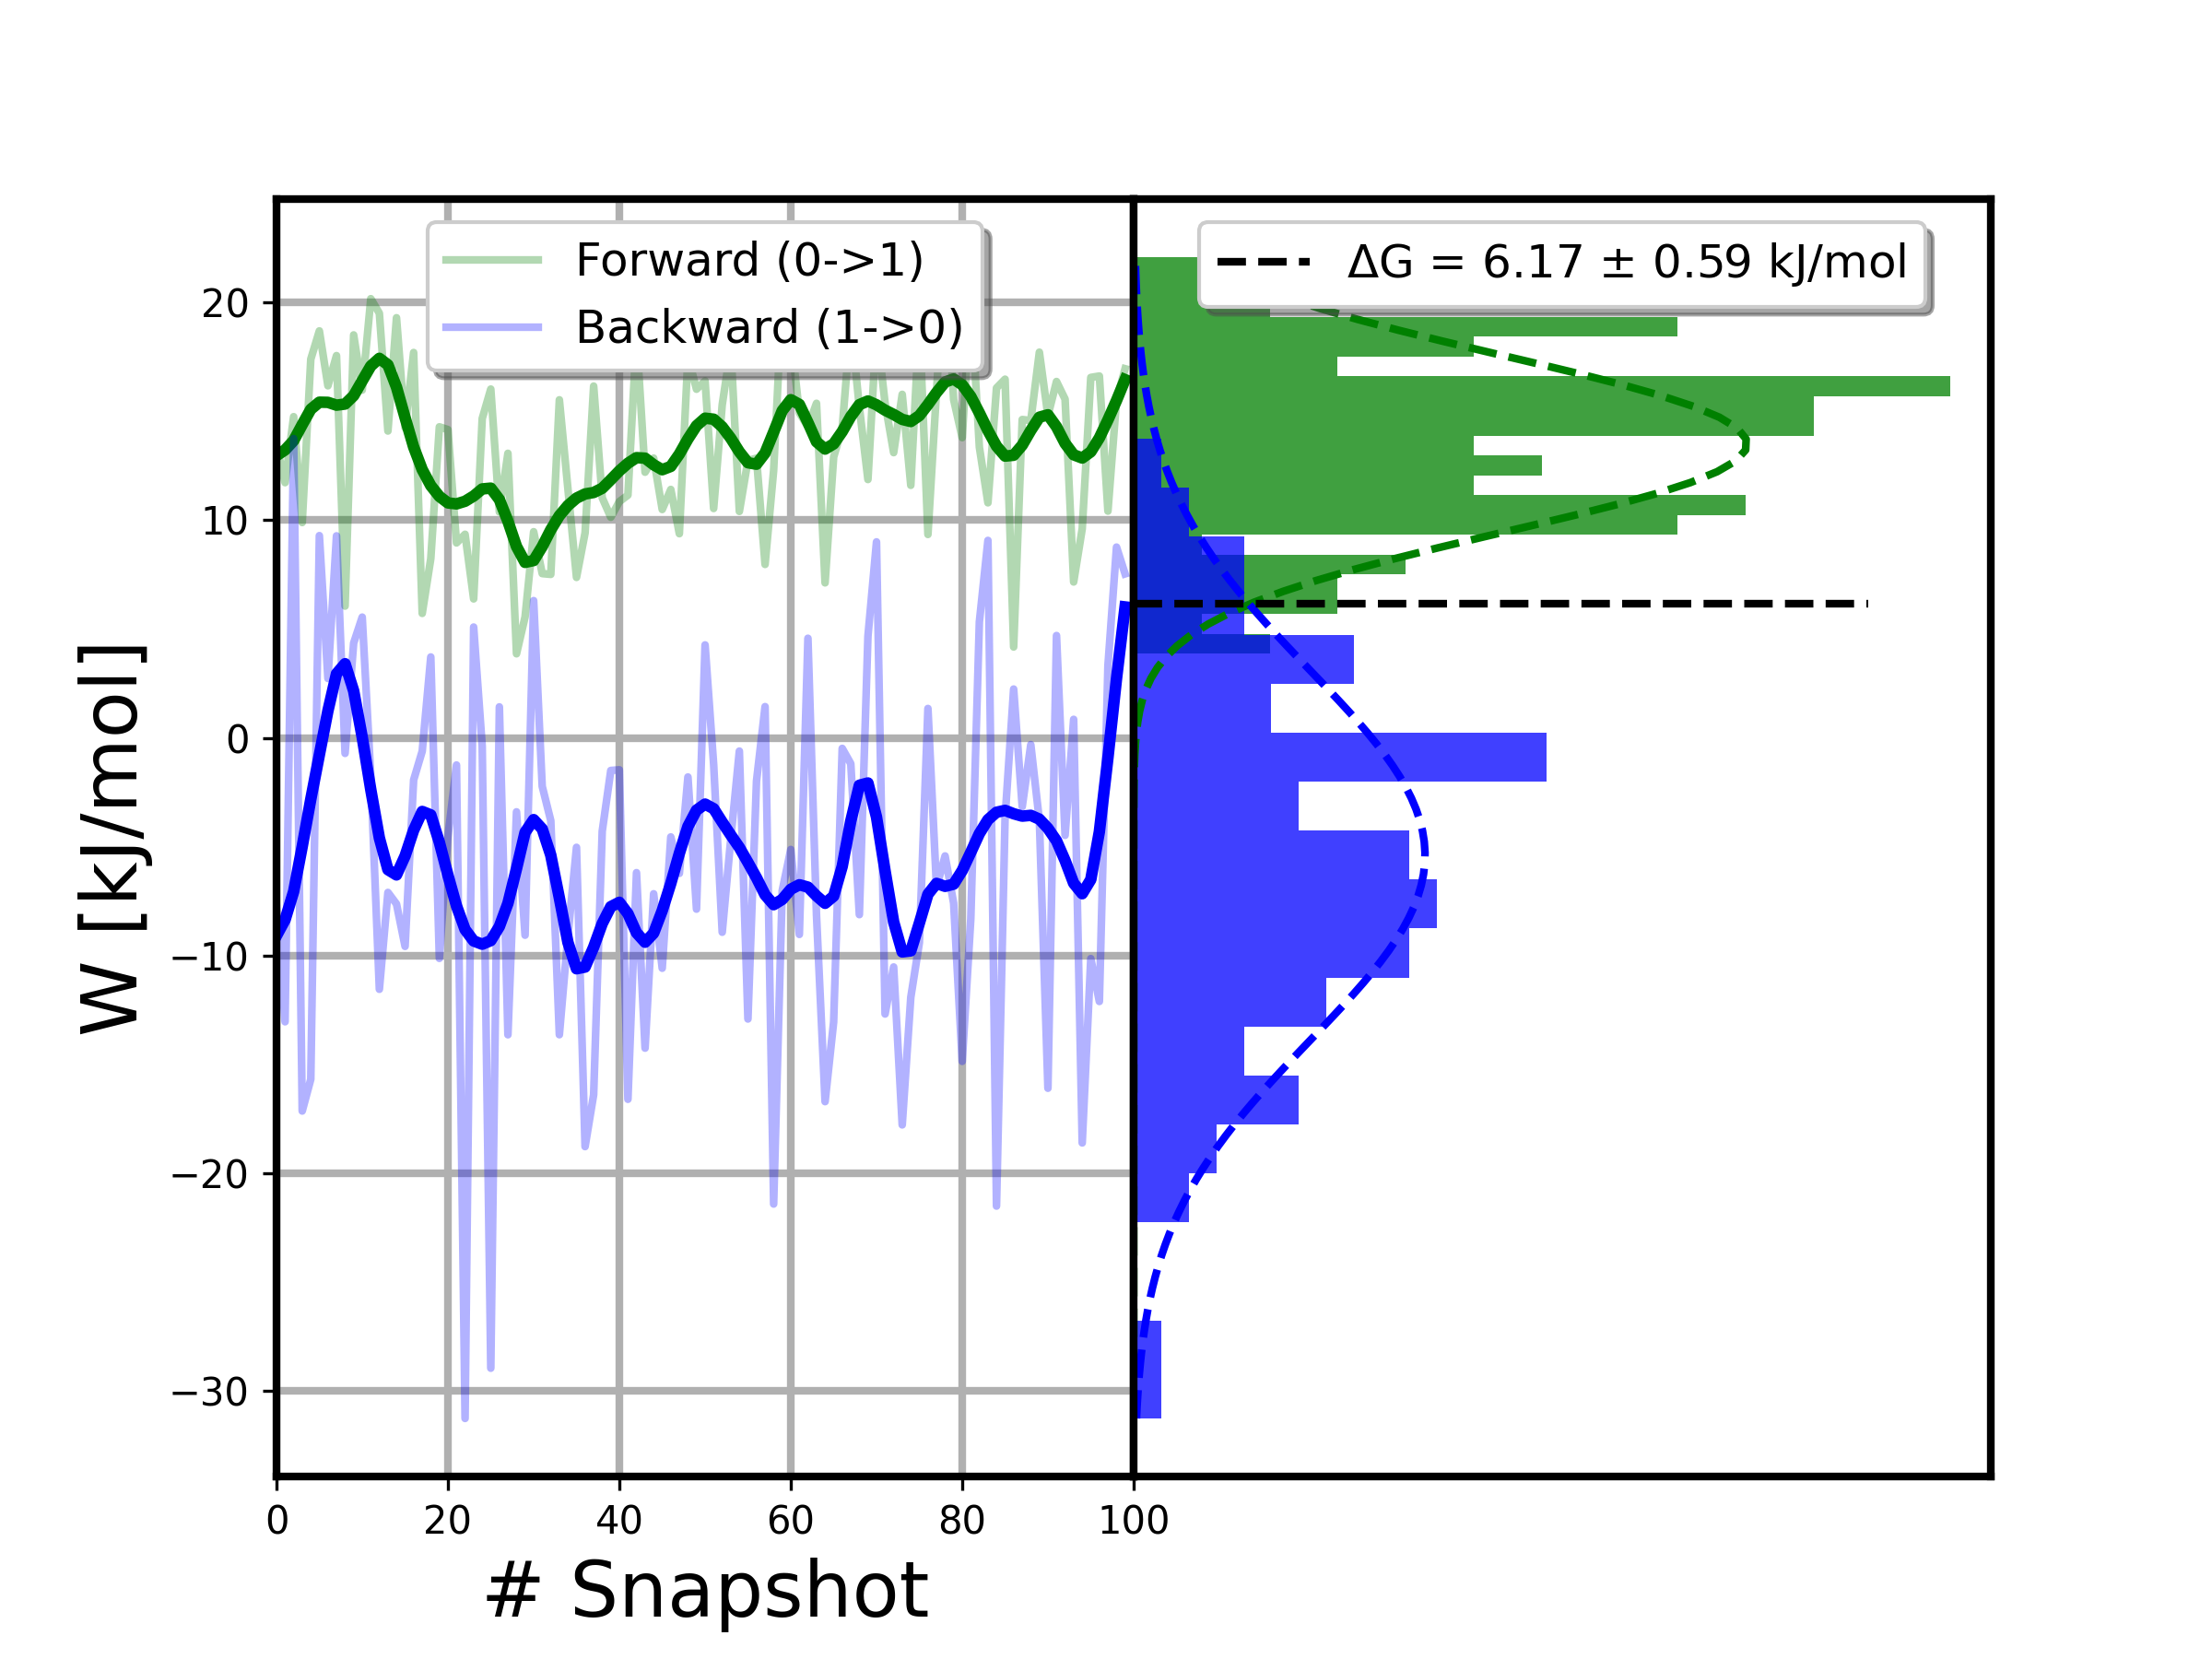

In [22]:
from IPython.display import Image
Image(filename=output_work_plot)

<a id="output"></a>
## Output files

Important **Output files** generated:
 - {{output_result}}: **Final free energy estimation**. Summary of information got applying the different methods.
 - {{output_work_plot}}: **Final free energy plot** of the **Mutation free energy** pipeline.

***
<a id="questions"></a>

## Questions & Comments

Questions, issues, suggestions and comments are really welcome!

* GitHub issues:
    * [https://github.com/bioexcel/biobb](https://github.com/bioexcel/biobb)

* BioExcel forum:
    * [https://ask.bioexcel.eu/c/BioExcel-Building-Blocks-library](https://ask.bioexcel.eu/c/BioExcel-Building-Blocks-library)
